# Custom Kernels

In this tutorial we will learn:

 * How to define a custom Kernel.
 
 * How to use it in a *dcgpy.expression_double*.
 
NOTE: when defining custom kernels directly via the python interface a slowdown is to be expected for two main reasons: 
 
 
 a) python callables cannot be called from different threads (only processes)  
 
 b) an added c++/python layer is added and forces conversions 

In [1]:
# Some necessary imports.
import dcgpy
from time import time
import pyaudi
# Sympy is nice to have for basic symbolic manipulation.
from sympy import init_printing
from sympy.parsing.sympy_parser import *
init_printing()
# Fundamental for plotting.
from matplotlib import pyplot as plt
%matplotlib inline

### 1 - Write the nonlinearity and its symbolic form

In [2]:
# Lets define some non-linear function we would like to use as a computational unit in a dCGP:
def my_fun(x):
    return exp(sum([it*it for it in x]))

# We need also to define the symbolic form of such a kernel so that, for example, symbolic manipulators 
# can understand its semantic. In this function x is to be interpreted as a list of symbols like ["x", "y", "z"]
def my_fun_print(x):
    return "exp(-" + "+".join([it + "**2" for it in x]) + ")"

# Note that it is left to the user to define a symbolic representation that makes sense and is truthful, no checks are done.
# All symbolic manipulations will rely on the fact that such a representation makes sense.

In [3]:
# ... and see by example how these functions work:
from numpy import exp
a = my_fun([0.2,-0.12,-0.0011])
b = my_fun_print(["x", "y", "z"])
print(b + " is: " + str(a))

exp(-x**2+y**2+z**2) is: 1.0559081580940681


### 2 - Define a dcgp.kernel with our new callables


In [4]:
# Since the nonlinearities we wrote can operate on gduals as well as on double we can define 
# both a kernel_double and a kernel_gdual_double (here we will only use the first one)
my_kernel_double = dcgpy.kernel_double(my_fun, my_fun_print, "my_gaussian")
my_kernel_gdual_double = dcgpy.kernel_gdual_double(my_fun, my_fun_print, "my_gaussian")

In [5]:
# For the case of doubles
a = my_kernel_double([0.2,-0.12,-0.0011])
b = my_kernel_double(["x", "y", "z"])
print(b + " evaluates to: " + str(a))
# And for the case of gduals
a = my_kernel_gdual_double([pyaudi.gdual_double(0.2, "x", 2),pyaudi.gdual_double(-0.12, "x", 2),pyaudi.gdual_double(-0.0011, "x", 2)])
b = my_kernel_gdual_double(["x", "y", "z"])
print(b + " evaluates to: " + str(a))

exp(-x**2+y**2+z**2) evaluates to: 1.0559081580940681
exp(-x**2+y**2+z**2) evaluates to: 3.18087*dx**2+1.05591+0.166622*dx


### 3 - Profiling the speed
Kernels defined in python introduce some slow down. Here we time 1000 calls to our exp(-x^2) function, when:

 * wrapped by the user in a python dcgpy.kernel
 * coming from the shipped dcgpy package (cpp implementation)
 * a normal python callable

In [6]:
# wrapped by the user in a python dcgpy.kernel
start = time()
_ = [my_kernel_double([i/1000, 0.3]) for i in range(1000)]
end =  time()
print("Elapsed (ms)", (end-start) * 1000)

Elapsed (ms) 7.709980010986328


In [7]:
# coming from the shipped dcgpy kernels (cpp implementation)
cpp_kernel = dcgpy.kernel_set_double(["gaussian"])[0]
start = time()
_ = [cpp_kernel([i/1000, 0.3]) for i in range(1000)]
end =  time()
print("Elapsed (ms)", (end-start) * 1000)

Elapsed (ms) 2.939939498901367


In [8]:
# a normal python callable
start = time()
_ = [my_fun([i/1000, 0.3]) for i in range(1000)]
end =  time()
print("Elapsed (ms)", (end-start) * 1000)

Elapsed (ms) 3.7784576416015625


### 4 - Using the new kernel in a dcpy.expression

In [9]:
ks = dcgpy.kernel_set_double(["sum", "mul", "diff"])
ks.push_back(my_kernel_double)
print(ks)

[sum, mul, diff, my_gaussian]


In [10]:
ex = dcgpy.expression_double(inputs=2,
                             outputs=1,
                             rows=1,
                             cols=6,
                             levels_back=6,
                             arity=2,
                             kernels=ks(),
                             n_eph=0,
                             seed = 39)
print(ex(["x", "y"]))

['((exp(-(x-y)**2+y**2)+(x-y))-y)']


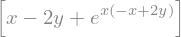

In [11]:
# We use the expression method simplify which is calling sympy. Since our symbolic representation
# of the Kernel is parsable by sympy, a simplified result is possible.
ex.simplify(["x", "y"])